## poliastro 构建的轨道传播算法 只考虑了J2

In [1]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator
# Astrodynamics libraries
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import cowell
from poliastro.core.perturbations import J2_perturbation
# from numba import njit
from poliastro.core.propagation import func_twobody

from astropy import units as u
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


import numpy as np
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator
# Astrodynamics libraries
from astropy import units as u
from astropy.time import Time
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import cowell
from poliastro.core.perturbations import J2_perturbation
# from numba import njit
from poliastro.core.propagation import func_twobody

from astropy import units as u
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


prop_time = 2

def f(t0, u_, k):
    du_kep = func_twobody(t0, u_, k)
    ax, ay, az = J2_perturbation(
        t0, u_, k, J2=Earth.J2.value, R=Earth.R.to(u.km).value
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])
    return du_kep + du_ad


def prop(state):
    s = prop_time

    r = state[0:3] * u.m
    v = state[3:6] * (u.m / u.s)
    orbit = Orbit.from_vectors(Earth, r, v)
    prop_orbit = orbit.propagate(s * u.s,
                                 method=cowell, f=f)

    prop_r, prop_v = prop_orbit.rv()
    prop_state_vect = np.concatenate([prop_r.to(u.m).to_value(), prop_v.to(u.m / u.s).to_value()])
    return prop_state_vect

def kep2car(state):

    a = state[0] * u.m
    ecc = state[1] * u.one
    inc = state[2] * u.deg
    raan = state[3] * u.deg
    argp = state[4] * u.deg
    nu = state[5] * u.deg
    orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
    
    orb_r, orb_v = orbit.rv()
    orb_state = np.concatenate([orb_r.to(u.m).to_value(), orb_v.to(u.m / u.s).to_value()])
    
    return orb_state

def car2kep(state):
    
    r = state[:3] * u.m
    v = state[3:] * u.m/u.s
    orbit = Orbit.from_vectors(Earth, r,v)
    
    a, ecc, inc, raan, argp, nu = orbit.classical()
    a = a.to(u.m).to_value()
    ecc = ecc.to_value()
    inc = inc.to(u.deg).to_value()
    raan = raan.to(u.deg).to_value()
    argp = argp.to(u.deg).to_value()
    nu = nu.to(u.deg).to_value()
    orb_state = np.array([a, ecc, inc, raan, argp, nu ])
    
    return orb_state

## space telescope Keplerian Elements

In [2]:
obs_tele_kep = np.array([6.87489699e+06, 1.46505319e-03, 9.80000000e+01, 2.43999767e+02,
       4.60830654e+01, 1.68944643e+02])

In [3]:
earth_R = 6378137
obs_height = obs_tele_kep[0] - earth_R 

In [4]:
obs_tele_car = kep2car(obs_tele_kep)
obs_tele_car

array([ 2.96576344e+06,  4.82609472e+06, -3.91321798e+06, -1.13339290e+03,
       -4.30085512e+03, -6.16690334e+03])

In [5]:
ini_obs_tele_car = list(obs_tele_car)
ini_obs_tele_car

[2965763.4420625097,
 4826094.719358868,
 -3913217.97914458,
 -1133.3928993179804,
 -4300.855122498339,
 -6166.903337085192]

In [6]:
## hypothesis orbit
import astropy.coordinates as coord
from astropy.coordinates import GCRS,ITRS,ICRS
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt

hypo_state = [6.87489699e+06, 1.46505319e-03, 9.80000000e+01, 2.43999767e+02, 4.60830654e+01, 1.68944643e+02]

hypo_tmp_car = []
hypo_tmp_kep = []

while True:
    
#     hypo_state[0] = random.uniform(10000000,12000000)
    hypo_state[0] = random.uniform(6700000,7200000)
    hypo_state[1] = random.uniform(0,0.02)
    hypo_state[2] = random.uniform(0,180)
    hypo_state[3] = random.uniform(0,360)
    hypo_state[4] = random.uniform(0,360)
    hypo_state[5] = random.uniform(-180,180)
    
    # hypothesis orbit Cartesian elements
    hypo_state1 = kep2car(hypo_state)
#     print(np.linalg.norm(hypo_state1[:3]))
    
    # 确保仿真的轨道合理
    if hypo_state[0] - hypo_state[0] * hypo_state[1]  > 6480000:

        hypo_tmp_car.append(list(hypo_state1)) # 仿真轨道的笛卡尔参数
        hypo_tmp_kep.append(list(hypo_state))  # 仿真轨道的开普勒参数

        if len(hypo_tmp_car)>=30:

            print('simulation done!')
            
            break

simulation done!


In [7]:
GM = 398600.4415 * 1e9  # JGM-3, Nominal Earth mass parameter.
R = 6378.137  # WGS-84, Nominal Earth equatorial radius.

In [8]:
# 输入某观测时刻的轨道笛卡尔位置 输出望远镜随机观测指向
def direction_tele(obs_tele_car):
    
    r = obs_tele_car[:3]
    v = obs_tele_car[3:]

    # LVLH
    # o3:LVLH Z-axis - Aligned with the spacecraft geocentric position vector
    # o2:LVLH Y-axis - Aligned with the negative orbit-normal
    # o1:LVLH X-axis - Completes the right-hand triad

    o3 = - r / (np.linalg.norm(r))
    o2 = - np.cross(r, v) / (np.linalg.norm(np.cross(r, v)))
    o1 = np.cross(o2, o3)

    rot = np.vstack((o1.T, o2.T, o3.T))
    rot_inv = np.linalg.inv(rot)

    # the random direction of space-based telescope

    LL = np.linalg.norm(r)
    earth_angle = np.arcsin((R * 1e3) / LL)
    earth_angle = (earth_angle * 180) / np.pi
    earth_angle = int(earth_angle) + 1

    theta = random.uniform(earth_angle, 180) # 让望远镜不指向地球
    phi = random.uniform(0, 360)

    return [theta, phi]

In [9]:
d_t = direction_tele(obs_tele_car)
d_t

[160.01025380824376, 114.33512971161552]

In [10]:
## 第一组仿真轨道的数据
hypo_tmp_car[0]

[3367431.442407937,
 6243650.022842467,
 463473.8881668997,
 6255.198126206918,
 -3591.5490368388437,
 2081.0693638986563]

In [11]:
np.save(file = 'low_hypo_tmp_car.npy',arr = hypo_tmp_car)

In [12]:
state = hypo_tmp_car[0]
state_series = []
for i in range(1000):
    state = prop(state)
    state_series.append(state)

In [13]:
state_series = np.array(state_series)

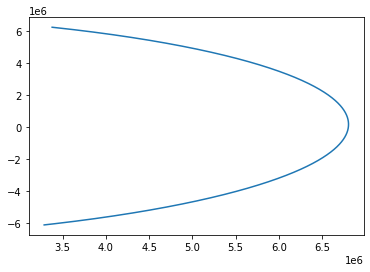

In [14]:
import matplotlib.pyplot as plt
plt.plot(state_series[:,0],state_series[:,1])

In [15]:
## 得到LVLH坐标下 space telescope 对空间目标的观测角

def tele_trans_LVLH(r, v):
    # LVLH
    # o3:LVLH Z-axis - Aligned with the spacecraft geocentric position vector
    # o2:LVLH Y-axis - Aligned with the negative orbit-normal
    # o1:LVLH X-axis - Completes the right-hand triad

    o3 = - r / (np.linalg.norm(r))
    o2 = - np.cross(r, v) / (np.linalg.norm(np.cross(r, v)))
    o1 = np.cross(o2, o3)

    rot = np.vstack((o1.T, o2.T, o3.T))

    return rot


def target_trans_LVLH(r, v, rot, r_t, r_v):
    r_d = r_t - r
    trans_r = np.dot(rot, r_d.T)

    # x,y,z --> sphercial
    z = trans_r[2]
    y = trans_r[1]
    x = trans_r[0]

    R = np.linalg.norm(trans_r)
    theta = np.arccos(z / R)  # [0 - pi]
    phi = np.arctan(y / x)  # [-pi/2, pi/2]

    theta = (theta * 180) / np.pi
    phi = (phi * 180) / np.pi

    if (y > 0) and (x < 0):
        phi += 180
    if (y < 0) and (x < 0):
        phi += 180
    if (y < 0) and (x > 0):
        phi += 360

    return R, theta, phi

## 测试30组仿真数据的观测情况

In [16]:
name = []
for i in range(0,30):
    name.append(str(i))

dic = {}
for i in name:
    dic[i] = []

In [ ]:
# obs_tele_pos_series = []
# tar_simu_pos_series = []


for j in range(3000):
    
    obs_tele_car = prop(obs_tele_car)

    r = np.array(obs_tele_car[:3])
    v = np.array(obs_tele_car[3:])
    rot = tele_trans_LVLH(r, v)

    theta_tmp = []
    phi_tmp = []
    R_tmp = []
    polar_tmp = []

    for i in range(len(hypo_tmp_car)):
        
        hypo_tmp_car[i] = prop(hypo_tmp_car[i])
        
        r_t = hypo_tmp_car[i][:3]
        r_v = hypo_tmp_car[i][3:]
        R, theta, phi = target_trans_LVLH(r, v, rot, r_t, r_v)
        
        diff_ta = theta - d_t[0]
        
        if abs(diff_ta) <= 4:
            
            R_tmp.append(R)
            theta_tmp.append(theta)
            phi_tmp.append(phi)
            polar = abs(R * np.sin((theta*np.pi)/180))
            polar_tmp.append(polar)
            
            name_ = str(i)
            dic[name_].append(2*j)
    
    if len(R_tmp):
        print(R_tmp)
        print('list is not none')
        plt.figure()
        ax1 = plt.subplot(111, projection='polar')
        ax1.scatter(phi_tmp, polar_tmp)
        plt.show()

In [ ]:
# np.save('dic_time.npy', dic)

In [ ]:
import pandas as pd

stat_pd = []
obs_time_tmp = []
for ii in range(30):
    name_ = str(ii)
    if len(dic[name_]):
#         print('{}   :   '.format(ii),len(dic[name_]))
        
        obs_time_tmp = []
        one_seg = dic['{}'.format(ii)]
        multi_seg = []
        for i in range(len(one_seg)-1):
            multi_seg.append(one_seg[i])
            if one_seg[i+1]-one_seg[i]>2:
                obs_time_tmp.append(multi_seg)
                multi_seg = []
            if i == len(one_seg)-2:
                multi_seg.append(one_seg[i+1])        
                obs_time_tmp.append(multi_seg)
        seg_num = len(obs_time_tmp)
        stat_pd.append([ii,len(dic[name_]),seg_num])

df = pd.DataFrame(stat_pd,columns=['number','total_num','segment_num'])
print(df)

In [ ]:
# obs_time_tmp = []
# aad = dic['9']
# aad0 = []
# for i in range(len(aad)-1):
#     aad0.append(aad[i])
#     if aad[i+1]-aad[i]>2:
#         obs_time_tmp.append(aad0)
#         aad0 = []
#     if i == len(aad)-2:
#         aad0.append(aad[i+1])        
#         obs_time_tmp.append(aad0)

In [ ]:
index_row = df['total_num'].argmax()
dic_select = df.iloc[index_row, 0]

In [ ]:
dic_select = 9

In [ ]:
# plt.plot(np.hstack((obs_time_tmp[0],obs_time_tmp[1],obs_time_tmp[2])))

In [ ]:
# len(obs_time_tmp)

In [ ]:
# obs_time_tmp

In [ ]:
ini_obs_tele_car

In [ ]:
obs_tele_car_ = list(ini_obs_tele_car)
i = dic_select
hypo_tmp_car_ = np.load('low_hypo_tmp_car.npy')[i]

test = {'time':[]}

obs_tele_tmp_ = []
tar_sat_tmp_ = []
index_arc = []
# obs_tele_tmp_.append(obs_tele_car_)
# tar_sat_tmp_.append(hypo_tmp_car_)

for j in range(3000):
    
    obs_tele_car_ = prop(obs_tele_car_)
    
    r = np.array(obs_tele_car_[:3])
    v = np.array(obs_tele_car_[3:])
    rot = tele_trans_LVLH(r, v)

    theta_tmp = []
    phi_tmp = []
    R_tmp = []
    polar_tmp = []
        
    hypo_tmp_car_ = prop(hypo_tmp_car_)
 
    obs_tele_tmp_.append(obs_tele_car_)
    tar_sat_tmp_.append(hypo_tmp_car_)
    
    r_t = hypo_tmp_car_[:3]
    r_v = hypo_tmp_car_[3:]
    R, theta, phi = target_trans_LVLH(r, v, rot, r_t, r_v)

    diff_ta = theta - d_t[0]

    if abs(diff_ta) <= 4:

        R_tmp.append(R)
        theta_tmp.append(theta)
        phi_tmp.append(phi)
        polar = abs(R * np.sin((theta*np.pi)/180))
        polar_tmp.append(polar)

        test['time'].append(2*j+2)
        index_arc.append(j)
        
        # 未保存初始时刻，是从传播后的第一时刻开始保存的，且传播间隔为 2 s，所以（2*j+2）
    
#     if len(R_tmp):
#         print(R_tmp)
#         print('list is not none')
#         plt.figure()
#         ax1 = plt.subplot(111, projection='polar')
#         ax1.scatter(phi_tmp, polar_tmp)
#         plt.show()

In [ ]:
# test['time']

In [ ]:
list(ini_obs_tele_car)

In [ ]:
# obs_tele_kep

In [ ]:
obs_tele_kep = np.array([6.87489699e+06, 1.46505319e-03, 9.80000000e+01, 2.43999767e+02,
       4.60830654e+01, 1.68944643e+02])

obs_tele_car = kep2car(obs_tele_kep)

In [ ]:
# one_segment = np.array(obs_time_tmp[0])+2
# len(one_segment)
one_segment = np.array(index_arc)
one_segment

In [ ]:
# one_segment = np.hstack((obs_time_tmp[0],obs_time_tmp[1]))+2
# len(one_segment)

In [ ]:
# i = 12

# tar_car = list(hypo_tmp_car_)
# tele_car = list(obs_tele_car)
# obs_tele_tmp = []
# tar_sat_tmp = []
# time = {'time': []}


# obs_tele_tmp.append(tele_car)
# tar_sat_tmp.append(tar_car)
# time['time'].append(prop_time*0)

# for j in range(3000):
    
#     tele_car = prop(tele_car)     
#     tar_car = prop(tar_car)
    
#     obs_tele_tmp.append(tele_car)
#     tar_sat_tmp.append(tar_car)
    
#     time['time'].append(prop_time*(j+1))

In [ ]:
[list(one_segment)]

In [ ]:
# np.array(test['time'])[list(one_segment)]

## 对某一个仿真轨道的观测数据处理，使其匹配到定轨算法

In [ ]:
obs_pos_tele = np.array(obs_tele_tmp_)[list(one_segment)]
obs_pos_unkn = np.array(tar_sat_tmp_)[list(one_segment)]

In [ ]:
sat_tele_diff = obs_pos_unkn - obs_pos_tele

In [ ]:
from astropy import coordinates as coord
from astropy import units as u
from astropy.time import Time
import random
from datetime import datetime,timedelta

ra_tmp = []
dec_tmp = []
ini_instant = list(one_segment)[0]
start_time = datetime(2008,1,1,0,0,0) + timedelta(seconds = 2*int(ini_instant))  
# print(start_time)
for i in range(len(obs_pos_tele)):
    obs_time = start_time + timedelta(seconds = 2*int(list(one_segment)[i]) - 2*int(ini_instant))
#     print(obs_time)
    now = Time(obs_time)
    cartrep = coord.CartesianRepresentation(x=sat_tele_diff[i,0], 
                                            y=sat_tele_diff[i,1],
                                            z=sat_tele_diff[i,2], unit=u.m)
    gcrs = coord.GCRS(cartrep,obstime=now)

    ra = gcrs.ra.to(u.deg).to_value() + random.gauss(0,0.001)
    dec = gcrs.dec.to(u.deg).to_value() + random.gauss(0,0.001)
    ra_tmp.append(ra)
    dec_tmp.append(dec)

In [ ]:
ini_date = datetime(2008,1,1,0,0,0) + timedelta(seconds = 2*int(ini_instant))  

obs_date = ini_date
rr = [obs_date.year,obs_date.month,obs_date.day, obs_date.hour, obs_date.minute, obs_date.second]

obs_1 = np.zeros((len(obs_pos_tele),11))
obs_1[0,:6] = [obs_date.year,obs_date.month,obs_date.day, obs_date.hour, obs_date.minute, obs_date.second]
obs_1[0,6:8] = [ra_tmp[0],dec_tmp[0]]
obs_1[0,8:11] = [np.array(obs_pos_tele)[0,0],np.array(obs_pos_tele)[0,1],np.array(obs_pos_tele)[0,2]]


for i in range(1,len(obs_pos_tele)):

    obs_date = start_time + timedelta(seconds = 2*int(list(one_segment)[i]) - 2*int(ini_instant))
    print(obs_date)
    obs_1[i,:6] = [obs_date.year,obs_date.month,obs_date.day, obs_date.hour, obs_date.minute, obs_date.second]
    obs_1[i,6:8] = [ra_tmp[i],dec_tmp[i]]
    obs_1[i,8:11] = [np.array(obs_pos_tele)[i][0],np.array(obs_pos_tele)[i][1],np.array(obs_pos_tele)[i][2]]

In [ ]:
i=0
f=open("obs_simu_fin_low.txt","w")

while i < len(obs_1): 
    

    for j in range(11):
        f.write(str(float(obs_1[i][j])))
        f.write(' ') 
    f.write('\n')
    
    i += 1
    
f.close()

In [ ]:
list(car2kep(hypo_tmp_car_))